The objective is to predict future sales of items in Favorita grocery stores across different regions of Ecuador. So that Reliable predictions can be helpful to optimize inventory management, prevent stockouts, and improve promotion strategies.

create a forecasting model for each product in each store in the region "Guayas" for January-March 2014, including March.

In [77]:
# Import libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Load Data

In [78]:
#from google.colab import drive
#drive.mount('/content/drive')

In [79]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('Data/stores.csv')
df_items = pd.read_csv('Data/items.csv')
df_transactions = pd.read_csv('Data/transactions.csv')
df_oil = pd.read_csv('Data/oil.csv')
df_holidays_events = pd.read_csv('Data/holidays_events.csv')

# filtered train
df_train = pd.read_csv('Data/train_Guayas.csv')

/var/folders/mh/fgvwq54x3dlg6k690k5t0qvh0000gn/T/ipykernel_4273/3445521968.py:9: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('Data/train_Guayas.csv')


In [136]:
df_train.isna().sum()

id                   0
date                 0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion    2747275
dtype: int64

## Stores

### Data Overview

In [80]:
# df_stores shape is 54 rows and 5 columns
#No null is found from the info
print(df_stores.info())
print('\n unique values \n', df_stores.nunique())
df_stores.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None

 unique values 
 store_nbr    54
city         22
state        16
type          5
cluster      17
dtype: int64


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### Focus on Guayas State

In [81]:
#Filtered stores located in the Guayas state
df_store_Guayas= df_stores[df_stores['state']=='Guayas']
print('Store shape is ', df_store_Guayas.shape)
df_store_Guayas

Store shape is  (11, 5)


,store_nbr,city,state,type,cluster
23,24,Guayaquil,Guayas,D,1
25,26,Guayaquil,Guayas,D,10
26,27,Daule,Guayas,D,1
27,28,Guayaquil,Guayas,E,10
28,29,Guayaquil,Guayas,E,10
29,30,Guayaquil,Guayas,C,3
31,32,Guayaquil,Guayas,C,3
33,34,Guayaquil,Guayas,B,6
34,35,Playas,Guayas,C,3
35,36,Libertad,Guayas,E,10


In [82]:
#Extracted store numbers (store_nbr) for use in downstream tasks like sales or location-based filtering
store_nbr_list_guayas = df_store_Guayas['store_nbr'].tolist()
print('Total number of store in Guayas\n', len(store_nbr_list_guayas))
print('Store number in Guayas ', store_nbr_list_guayas)

Total number of store in Guayas
 11
Store number in Guayas  [24, 26, 27, 28, 29, 30, 32, 34, 35, 36, 51]


## Items

In [83]:
# NO null from the info check
print(df_items.info())
#print('\n unique values \n', df_items.nunique())
df_items.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_nbr    4100 non-null   int64 
 1   family      4100 non-null   object
 2   class       4100 non-null   int64 
 3   perishable  4100 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 128.3+ KB
None


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [84]:
## Filter items to include only relevant product from top 3 families
# Compute the number of items per family and select the top 3 families
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['family', 'Item Count']
top_3_families = items_per_family.head(3)
top_3_families



,family,Item Count
0,GROCERY I,1334
1,BEVERAGES,613
2,CLEANING,446


In [85]:
filtered_df_items = df_items[df_items['family'].isin(top_3_families['family'])]
filtered_df_items

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
5,105574,GROCERY I,1045,0
...,...,...,...,...
4094,2132163,GROCERY I,1040,0
4095,2132318,GROCERY I,1002,0
4096,2132945,GROCERY I,1026,0
4097,2132957,GROCERY I,1068,0


In [86]:
# Visualize the distribution of perishability within selected product families

#print(filtered_df_items['perishable'].value_counts())
#filtered_df_items['perishable'].value_counts().plot(kind='bar')

## Transactions

### Data overview

In [87]:
# df_transactions shape is 83488 rows and 3 columns
#No null is found from the info

print(df_transactions.info())
print('\n unique value number \n', df_transactions.nunique())
df_transactions.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB
None

 unique value number 
 date            1682
store_nbr         54
transactions    4993
dtype: int64


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [88]:
#Convert date to datetime format:
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
df_transactions['date'].min(), df_transactions['date'].max()
#print(df_transactions['store_nbr'].nunique())


(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

### Filter transactions for stores in Guayas


In [89]:
df_transactions_guayas = df_transactions[df_transactions['store_nbr'].isin(store_nbr_list_guayas)]
df_transactions_guayas['date'] = pd.to_datetime(df_transactions_guayas['date'])
df_transactions_guayas

/var/folders/mh/fgvwq54x3dlg6k690k5t0qvh0000gn/T/ipykernel_4273/2040464096.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transactions_guayas['date'] = pd.to_datetime(df_transactions_guayas['date'])


,date,store_nbr,transactions
21,2013-01-02,24,2605
23,2013-01-02,26,1008
24,2013-01-02,27,1386
25,2013-01-02,28,950
26,2013-01-02,30,708
...,...,...,...
83465,2017-08-15,32,615
83467,2017-08-15,34,2007
83468,2017-08-15,35,612
83469,2017-08-15,36,1192


<Axes: title={'center': 'Total Transactions Across All Stores'}, xlabel='date'>

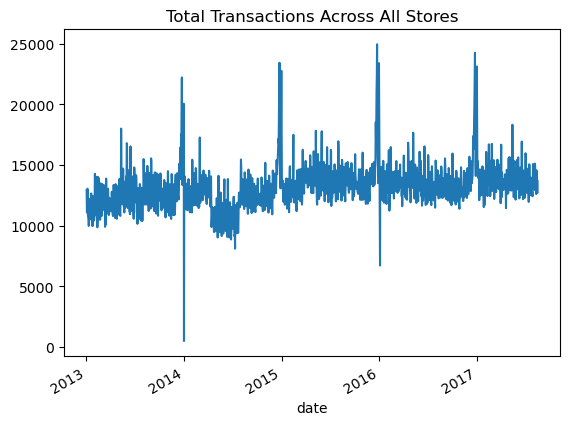

In [90]:
#Set multi-index if needed (date + store):
df_transactions_guayas.set_index(['date', 'store_nbr'], inplace=True)

## Plot total transactions over time
df_transactions_guayas.groupby('date')['transactions'].sum().plot(title='Total Transactions Across All Stores')

High sale spikes during year end fpr each year. 

In [91]:
#Show total transactions for each stores in Guayas
df_transactions_guayas.groupby('store_nbr')['transactions'].sum().sort_values(ascending=False).reset_index(name='total_transactions')

,store_nbr,total_transactions
0,34,3864018
1,24,3568206
2,51,2873614
3,27,2485687
4,28,1957594
5,36,1738129
6,30,1171130
7,35,1123889
8,32,1065226
9,26,1065059


## Oil

### Data overview

In [92]:
# df_oil contains 1218 rows and 2 columns
#No null is found from the info
print(df_oil.info())
print('\n Unique value \n', df_oil.nunique())
print('\n Null value\n',df_oil.isnull().sum())
df_oil.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None

 Unique value 
 date          1218
dcoilwtico     998
dtype: int64

 Null value
 date           0
dcoilwtico    43
dtype: int64


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [93]:
#calculate the date range in the dataset spans covering daily oil prices.
print('The date range for oil is ',df_oil['date'].min(), 'to', df_oil['date'].max())
print(len(df_oil['date'].unique()))

The date range for oil is  2013-01-01 to 2017-08-31
1218


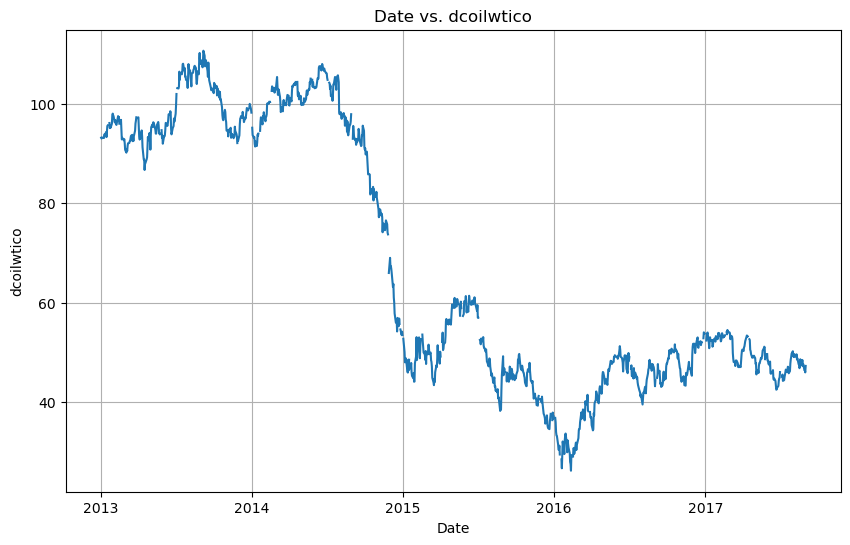

In [94]:
#Visualize the trend in oil prices over time.

df_oil['date'] = pd.to_datetime(df_oil['date'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(df_oil['date'], df_oil['dcoilwtico'])
plt.xlabel('Date')
plt.ylabel('dcoilwtico')
plt.title('Date vs. dcoilwtico')
plt.grid(True)
plt.show()


## Holiday Events

### Data Overview

In [95]:
# df_transactions shape is 350 rows and 6 columns
#No null is found from the info

print(df_holidays_events.info())
print('\n Unique values \n', df_holidays_events.nunique())
print('\n Duplicate values \n', df_holidays_events.duplicated().sum())
df_holidays_events.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None

 Unique values 
 date           312
type             6
locale           3
locale_name     24
description    103
transferred      2
dtype: int64

 Duplicate values 
 0


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [96]:
print('\n Unique locale names \n', df_holidays_events['locale_name'].value_counts())


 Unique locale names 
 locale_name
Ecuador                           174
Quito                              13
Riobamba                           12
Guaranda                           12
Latacunga                          12
Ambato                             12
Guayaquil                          11
Cuenca                              7
Ibarra                              7
Salinas                             6
Loja                                6
Santa Elena                         6
Santo Domingo de los Tsachilas      6
Quevedo                             6
Manta                               6
Esmeraldas                          6
Cotopaxi                            6
El Carmen                           6
Santo Domingo                       6
Machala                             6
Imbabura                            6
Puyo                                6
Libertad                            6
Cayambe                             6
Name: count, dtype: int64


In [97]:
print('\n Unique locale values \n', df_holidays_events['locale'].value_counts())


 Unique locale values 
 locale
National    174
Local       152
Regional     24
Name: count, dtype: int64


In [98]:
print('\n Unique type values \n', df_holidays_events['type'].value_counts())


 Unique type values 
 type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64


### Data Exploration

Examined unique values in key columns like locale, locale_name, and type

In [99]:
#df_holidays_events[df_holidays_events['type']=='Event']
#df_holidays_events[df_holidays_events['locale']=='Regional']
df_holidays_events[df_holidays_events['locale']=='Local']


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
...,...,...,...,...,...,...
339,2017-12-05,Additional,Local,Quito,Fundacion de Quito-1,False
340,2017-12-06,Holiday,Local,Quito,Fundacion de Quito,True
341,2017-12-08,Holiday,Local,Loja,Fundacion de Loja,False
342,2017-12-08,Transfer,Local,Quito,Traslado Fundacion de Quito,False


In [100]:
national= df_holidays_events[df_holidays_events['locale']=='National']
print(national['locale_name'].value_counts())
national

locale_name
Ecuador    174
Name: count, dtype: int64


,date,type,locale,locale_name,description,transferred
14,2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
21,2012-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [101]:
local_filtered = df_holidays_events[df_holidays_events['locale'].isin(['Local', 'National'])]
local_filtered

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [102]:
#Filtering transferred holidays
print(df_holidays_events['transferred'].value_counts())
df_holidays_events[df_holidays_events['transferred']==True]

transferred
False    338
True      12
Name: count, dtype: int64


,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
255,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
266,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
268,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
297,2017-01-01,Holiday,National,Ecuador,Primer dia del ano,True
303,2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,True
312,2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
324,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True


In [103]:
df_holidays_events[df_holidays_events['type']=='Transfer']

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
304,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


In [104]:
#Filtering additional holidays
df_holidays_events[df_holidays_events['type']=='Additional'].head(5)

,date,type,locale,locale_name,description,transferred
28,2012-12-05,Additional,Local,Quito,Fundacion de Quito-1,False
31,2012-12-21,Additional,National,Ecuador,Navidad-4,False
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
34,2012-12-23,Additional,National,Ecuador,Navidad-2,False
36,2012-12-24,Additional,National,Ecuador,Navidad-1,False


In [105]:
#Filtering for Bridge and Work Day Events
df_holidays_events[(df_holidays_events['type'] == 'Bridge') | (df_holidays_events['type'] == 'Work Day')]

,date,type,locale,locale_name,description,transferred
35,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
39,2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano,False
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
149,2014-12-20,Work Day,National,Ecuador,Recupero Puente Navidad,False
156,2014-12-26,Bridge,National,Ecuador,Puente Navidad,False
160,2015-01-02,Bridge,National,Ecuador,Puente Primer dia del ano,False
161,2015-01-10,Work Day,National,Ecuador,Recupero Puente Primer dia del ano,False
277,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos,False
283,2016-11-12,Work Day,National,Ecuador,Recupero Puente Dia de Difuntos,False


### Feature Engineering

Create two new columns called is_holiday ans is_event

In [106]:
#is_holiday:Mark rows as is_holiday = 1 if: type == 'Holiday' and transferred == False OR type is one of these: 'Additional', 'Bridge', 'Transfer'
#is_event: Checks if each row in the "type" column is "Event". If yes → returns 1. If no → returns 0

df_holidays_events['is_holiday'] = np.where(
    ((df_holidays_events['type'] == 'Holiday') & (df_holidays_events['transferred'] == False)) |
    (df_holidays_events['type'].isin(['Additional', 'Bridge', 'Transfer'])),
    1,
    0
)

df_holidays_events['is_event'] = np.where(df_holidays_events['type'] == 'Event', 1, 0)
df_holidays_events

,date,type,locale,locale_name,description,transferred,is_holiday,is_event
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,1,0
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,1,0
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,1,0
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1,0
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,1,0
...,...,...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False,1,0
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False,1,0
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False,1,0
348,2017-12-25,Holiday,National,Ecuador,Navidad,False,1,0


### Analyzing Holidays in Guayas Province

In this analysis, we focus on understanding the distribution of holidays in Guayas province, Ecuador.

In [114]:
# Filtering City for Guayas
city_guayas=df_store_Guayas['city'].unique().tolist()
city_guayas

['Guayaquil', 'Daule', 'Playas', 'Libertad']

In [117]:
# Filter holiday data to include only relevant cities in Guayas.
filtered_holidays_guayas = df_holidays_events[
    df_holidays_events['locale_name'].isin(['Guayaquil', 'Daule', 'Playas', 'Libertad'])
]
filtered_holidays_guayas_local= filtered_holidays_guayas[filtered_holidays_guayas['locale']=='Local']
filtered_holidays_guayas

,date,type,locale,locale_name,description,transferred,is_holiday,is_event
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1,0
49,2013-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1,0
64,2013-07-24,Additional,Local,Guayaquil,Fundacion de Guayaquil-1,False,1,0
65,2013-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,False,1,0
98,2014-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1,0
127,2014-07-24,Additional,Local,Guayaquil,Fundacion de Guayaquil-1,False,1,0
128,2014-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,False,1,0
168,2015-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1,0
182,2015-07-24,Holiday,Local,Guayaquil,Fundacion de Guayaquil-1,False,1,0
183,2015-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,False,1,0


/var/folders/mh/fgvwq54x3dlg6k690k5t0qvh0000gn/T/ipykernel_4273/3428199433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=locale_counts, x='locale', y='count', palette='pastel')


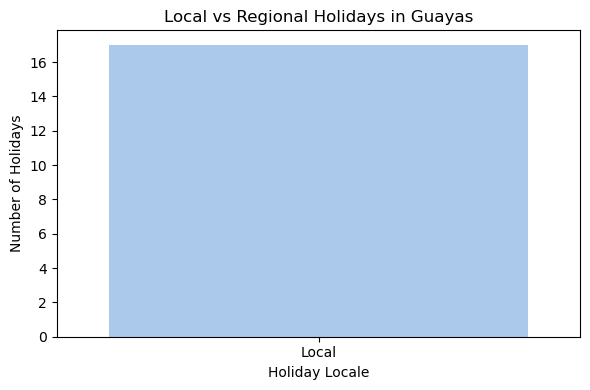

In [118]:
# Visualize the count of Local vs Regional holidays.
locale_counts = filtered_holidays_guayas['locale'].value_counts().reset_index()
locale_counts.columns = ['locale', 'count']

plt.figure(figsize=(6, 4))
sns.barplot(data=locale_counts, x='locale', y='count', palette='pastel')
plt.title('Local vs Regional Holidays in Guayas')
plt.xlabel('Holiday Locale')
plt.ylabel('Number of Holidays')
plt.tight_layout()
plt.show()

/var/folders/mh/fgvwq54x3dlg6k690k5t0qvh0000gn/T/ipykernel_4273/288848133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_holidays_guayas['date'] = pd.to_datetime(filtered_holidays_guayas['date'])
/var/folders/mh/fgvwq54x3dlg6k690k5t0qvh0000gn/T/ipykernel_4273/288848133.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_holidays_guayas['year'] = filtered_holidays_guayas['date'].dt.year


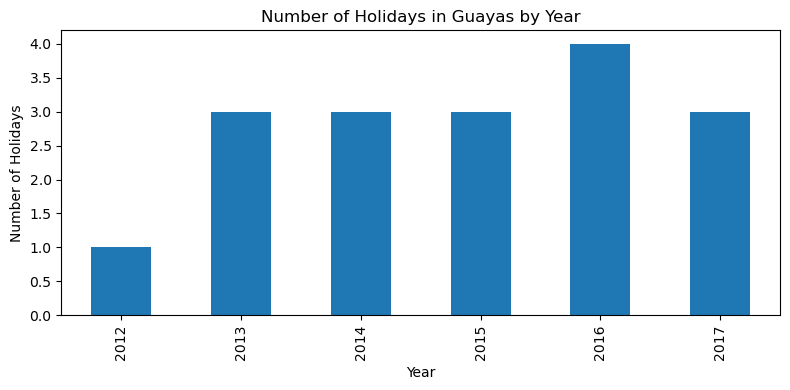

In [119]:
# Analyze the trend of holidays over years.
filtered_holidays_guayas['date'] = pd.to_datetime(filtered_holidays_guayas['date'])
filtered_holidays_guayas['year'] = filtered_holidays_guayas['date'].dt.year
holiday_counts_by_year = filtered_holidays_guayas.groupby('year').size()

holiday_counts_by_year.plot(kind='bar', title='Number of Holidays in Guayas by Year', figsize=(8, 4))
plt.xlabel('Year')
plt.ylabel('Number of Holidays')
plt.tight_layout()
plt.show()


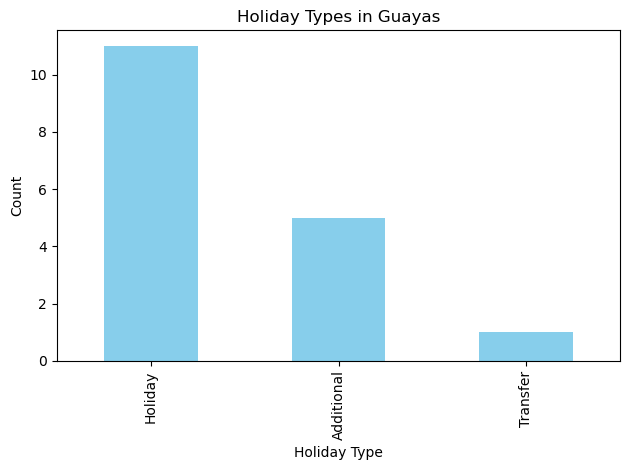

In [120]:
# Visiualize the holiday types in Guayas

filtered_holidays_guayas['type'].value_counts().plot(
    kind='bar', title='Holiday Types in Guayas', color='skyblue'
)
plt.xlabel('Holiday Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

/var/folders/mh/fgvwq54x3dlg6k690k5t0qvh0000gn/T/ipykernel_4273/692472795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_holidays_guayas['month'] = filtered_holidays_guayas['date'].dt.month


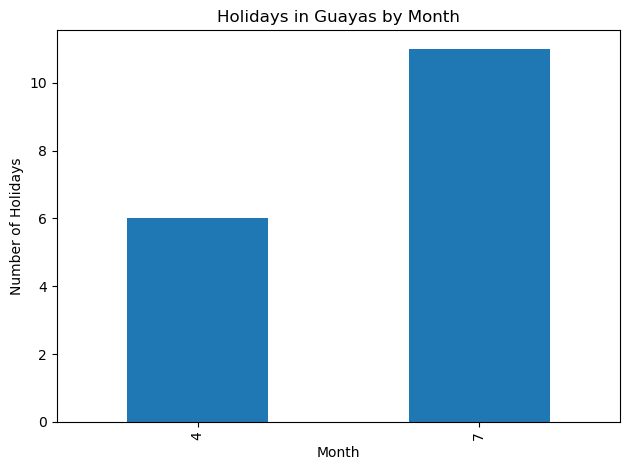

In [121]:
# Explore seasonality by looking at holidays per month.
filtered_holidays_guayas['month'] = filtered_holidays_guayas['date'].dt.month
filtered_holidays_guayas['month'].value_counts().sort_index().plot(
    kind='bar', title='Holidays in Guayas by Month'
)
plt.xlabel('Month')
plt.ylabel('Number of Holidays')
plt.tight_layout()
plt.show()

## Filtered Train

### Data Overview

In [124]:
# df_train has 14745768 rows and 6 columns
#No null is found from the info
print(df_train.info())
print('\n Unique values \n', df_train.nunique())
print('\n Null values \n',df_train.isnull().sum())
df_train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14745768 entries, 0 to 14745767
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   item_nbr     int64  
 4   unit_sales   float64
 5   onpromotion  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 675.0+ MB
None

 Unique values 
 id             14745768
date               1680
store_nbr            11
item_nbr           2323
unit_sales         4537
onpromotion           2
dtype: int64

 Null values 
 id                   0
date                 0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion    2747275
dtype: int64


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,18790,2013-01-02,24,105574,12.0,NaN
1,18791,2013-01-02,24,105575,2.0,NaN
2,18792,2013-01-02,24,105577,1.0,NaN
3,18793,2013-01-02,24,105693,7.0,NaN
4,18794,2013-01-02,24,105737,17.0,NaN


In [125]:
# Count of promotions
df_train['onpromotion'].value_counts()

onpromotion
False    11319196
True       679297
Name: count, dtype: int64

### Data exploration

<Axes: title={'center': 'Total Unit Sales Over Time in Guayas'}, xlabel='date'>

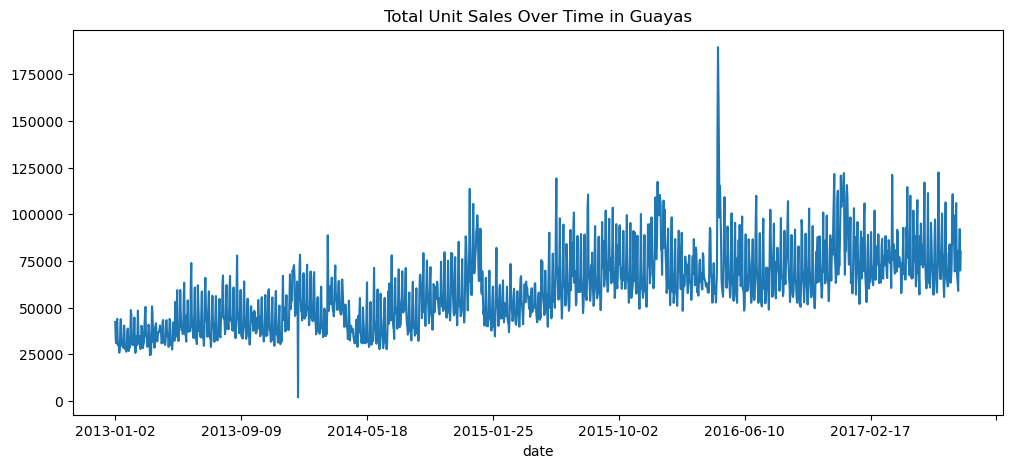

In [126]:
#Total unit sales per day

daily_sales = df_train.groupby('date')['unit_sales'].sum()
daily_sales.plot(title="Total Unit Sales Over Time in Guayas", figsize=(12,5))

In [130]:
# Zero and negative sales counts
unique_dates = df_train['date'].unique()
print('Total unique dates',len(unique_dates))

zero_sales_train=df_train[df_train['unit_sales']==0]
print('Total zero sales',len(zero_sales_train))

# Check for negative sales
negative_sales_train=df_train[df_train['unit_sales']<0]
print('Total negative sales number',len(negative_sales_train))

Total unique dates 1680
Total zero sales 0
Total negative sales number 794


### Analysis of Top Selling Items in the Guayas Region

This analysis identifies the top 10 selling items across all stores located in the Guayas region.



In [ ]:
# Total sales per item for each store in the Guayas region

# Merging the sales data with store and Filter for Guayas state.
guayas_data = pd.merge(df_train, df_stores, on='store_nbr')
guayas_data = guayas_data[guayas_data['state'] == 'Guayas']

# Aggregating total unit sales by item and store.
sales_summary = guayas_data.groupby(['store_nbr', 'item_nbr'])['unit_sales'].sum().reset_index()
sales_summary

,store_nbr,item_nbr,unit_sales
0,24,96995,424.0
1,24,99197,417.0
2,24,103520,5929.0
3,24,105574,16226.0
4,24,105575,12461.0
...,...,...,...
20783,51,2123727,6.0
20784,51,2123750,3.0
20785,51,2123775,1.0
20786,51,2123791,1.0


/var/folders/mh/fgvwq54x3dlg6k690k5t0qvh0000gn/T/ipykernel_4273/3512112038.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_items, x='item_nbr', y='unit_sales', palette='viridis')


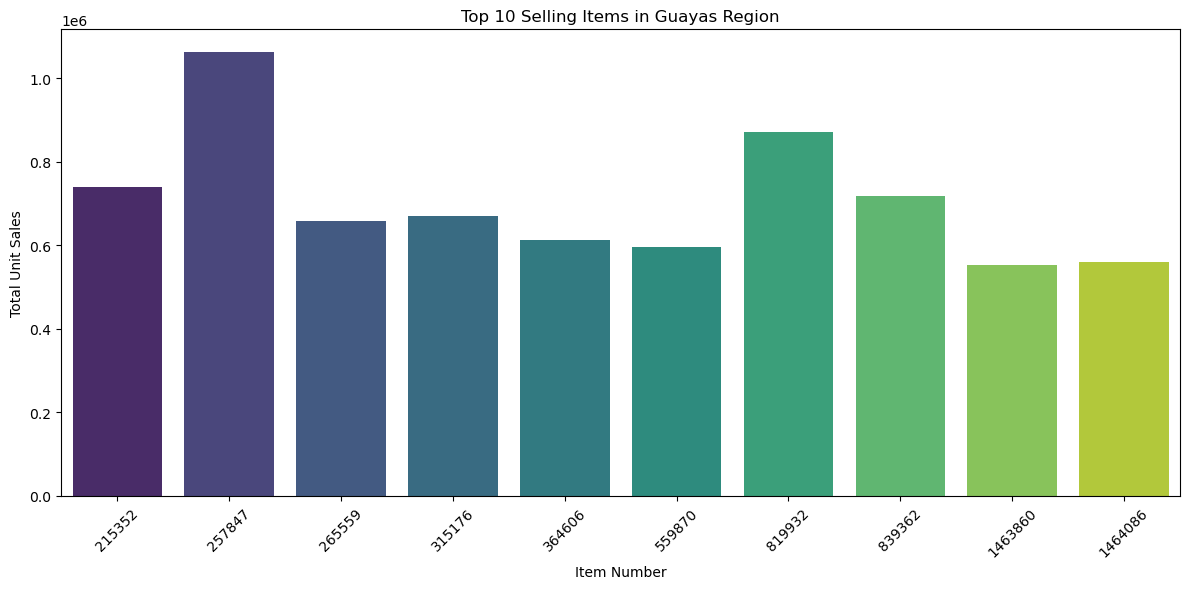

In [ ]:
#Summarizing and visualizing the top 10 items with the highest unit sales.

# Get top 10 selling items across all Guayas stores
top_items = sales_summary.groupby('item_nbr')['unit_sales'].sum().nlargest(10).reset_index()

# Plot top 10 selling items
plt.figure(figsize=(12, 6))
sns.barplot(data=top_items, x='item_nbr', y='unit_sales', palette='viridis')
plt.title('Top 10 Selling Items in Guayas Region')
plt.xlabel('Item Number')
plt.ylabel('Total Unit Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save processed holiday_events and download

In [133]:
df_holidays_events.to_csv('holidays_events_processed.csv', index= False)

In [ ]:
#from google.colab import files
#files.download('holidays_events_processed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [134]:
#Save featured data
df_holidays_events.to_csv('Data/holidays_events_processed.csv', index=False)
#Read data automatically from drive
df_holidays_events = pd.read_csv('Data/holidays_events_processed.csv')

In [135]:
df_holidays_events.shape

(350, 8)